# Tutoriel : Créer une prévision STEPS (Nowcast) avec HSAF

Dans ce notebook, nous allons créer un nowcast étape par étape.
Ce notebook reprend le travail du premier notebook, où les données HSAF-H60B ont été téléchargées et prétraitées. Le dossier processed contenant ces fichiers servira d’entrée pour la prévision.

Pour réaliser le nowcast, nous utilisons la bibliothèque pysteps et le script de nowcast déjà préparé, disponible via EnhancedStepsNowcast.

Nous allons :

1. Charger les derniers fichiers prétraités,

2. Sélectionner la région d’intérêt,

3. Lancer le nowcast (méthode déterministe),

4. Visualiser et exporter la prévision.


In [1]:
# Ici, nous chargeons les bibliothèques nécessaires.
import glob
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from datetime import datetime, timedelta, date
import pandas as pd
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import cartopy.crs as ccrs
from pathlib import Path
import math

# Charger la fonction de nowcast et le package PySTEPS
from enhanced_steps import EnhancedStepsNowcast
print("Toutes les bibliothèques ont été importées avec succès!")

Pysteps configuration file found at: /home/vscode/.local/lib/python3.10/site-packages/pysteps/pystepsrc

Toutes les bibliothèques ont été importées avec succès!


# Étape 1 : Définir la structure des dossiers de données

In [2]:
# Créer les dossiers pour nos données
data_folder = Path("./h60b_data")
processed_folder = data_folder / "processed"		#Il s'agit du dossier où, dans le script de prétraitement, les fichiers de précipitations traités ont été enregistrés.
nowcasting_folder = data_folder / "nowcast"

# Créer le dossier pour les prévisions
Path(nowcasting_folder).mkdir(parents=True, exist_ok=True)

# Étape 2 : Paramètres pour le nowcast
Ces paramètres définissent comment le nowcast sera exécuté : la source des données, le nombre de fichiers d’entrée, le nombre de pas de temps à prévoir, la fréquence, les transformations, les seuils pour distinguer pluie / pas de pluie, et les paramètres pour la parallélisation.

In [3]:
settings = {
    "data_source": "h60b",     # Source des données
    "ensemble": 5,             # Nombre de membres de l'ensemble
    "n_input_files": 10,       # Nombre de fichiers d'entrée utilisés
    "n_lead_times": 12,        # Nombre de pas de temps à prévoir, chaque pas de temps dure 15 minutes
    "frequency": 15,           # Minutes entre chaque pas de temps
    "transform": "dB",         # Transformation utilisée par pysteps ("dB", "log", ...)
    "threshold": 0.05,         # Seuil (mm/h) pour définir pluie / pas de pluie
    "buffer_distance": 500,    # Distance en mètres autour du pays pour le découpage
    "crs_out": "EPSG:4326",    # Système de coordonnées de sortie
    "norain_thr": 0.005,       # Paramètres pour la méthode Norain
    "zerovalue": -15.0,        # Paramètres pour la méthode Norain
    "max_workers": 2,          # Nombre de processeurs à utiliser
}


# Étape 3 : Rechercher les fichiers HSAF téléchargés et prétraités

In [4]:
# --- Liste de tous les fichiers disponibles ---
all_files = sorted(processed_folder.glob("*H60B*.nc"))
print("Tous les fichiers HSAF disponibles dans le dossier :\n")
for i, f in enumerate(all_files):
    print(f"{i}: {f.name}")

Tous les fichiers HSAF disponibles dans le dossier :

0: HSAF-H60B_20250810T080000.nc
1: HSAF-H60B_20250810T081500.nc
2: HSAF-H60B_20250810T083000.nc
3: HSAF-H60B_20250810T084500.nc
4: HSAF-H60B_20250810T090000.nc
5: HSAF-H60B_20250810T091500.nc
6: HSAF-H60B_20250810T093000.nc
7: HSAF-H60B_20250810T094500.nc
8: HSAF-H60B_20250810T100000.nc
9: HSAF-H60B_20250810T101500.nc


In [5]:
def find_latest_inputs(processed_folder, n=10, start_file=None):
    """
    Récupère les fichiers HSAF prétraités pour le nowcast.

    """
    # Lister tous les fichiers H60B et trier
    all_files = sorted(processed_folder.glob("*H60B*.nc"))
    
    if start_file is None:
        # Mode standard : les n derniers fichiers
        return list(reversed(all_files))[:n]
    else:
        # Mode start_file : trouver l'index du fichier de départ
        start_file = Path(start_file).name  # seulement le nom
        indices = [i for i, f in enumerate(all_files) if f.name == start_file]
        if not indices:
            raise ValueError(f"Le fichier de départ '{start_file}' n'a pas été trouvé dans le dossier.")
        start_idx = indices[0]
        # Retourner n fichiers à partir de start_idx
        return all_files[start_idx:start_idx + n]

# Mode 1 : derniers fichiers
input_files = find_latest_inputs(processed_folder, n=10)

# Mode 2 : à partir d'un fichier de départ
# start_file = processed_folder / "HSAF-H60B_20250810T080000.nc"
# input_files = find_latest_inputs(processed_folder, n=10, start_file=start_file)

input_files

[PosixPath('h60b_data/processed/HSAF-H60B_20250810T101500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250810T100000.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250810T094500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250810T093000.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250810T091500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250810T090000.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250810T084500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250810T083000.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250810T081500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250810T080000.nc')]

# Étape 4 : Charger les fichiers d'entrée pour le nowcast
Ici, les différentes couches de données correspondant aux différents pas de temps sont combinées en un seul fichier de données à trois dimensions : x (longitude), y (latitude) et temps.

Ce fichier unique servira ensuite d’entrée pour notre prévision immédiate (nowcast).

In [6]:
def open_as_time_stack(input_files):
    """
    Cette fonction ouvre tous les fichiers HSAF prétraités sélectionnés et les combine
    en une seule structure xarray Dataset avec la dimension 'time'.

    """
    if not input_files:
        raise FileNotFoundError("Aucun fichier d'entrée trouvé.")   # Vérifie qu'il y a des fichiers
    datasets = xr.open_mfdataset(input_files)                       # Ouvre tous les fichiers et les combine
    return datasets

# Charger les fichiers sélectionnés et créer un Dataset avec la dimension temps
input_dataset = open_as_time_stack(input_files)

# Afficher le Dataset pour vérifier son contenu
display(input_dataset)

<xarray.Dataset> Size: 549MB
Dimensions:           (time: 10, y: 3537, x: 3879)
Coordinates:
  * x                 (x) float64 31kB -81.26 -81.22 -81.18 ... 81.22 81.26
  * y                 (y) float64 28kB 74.16 74.12 74.07 ... -73.99 -74.03
  * time              (time) datetime64[ns] 80B 2025-08-10T08:00:00 ... 2025-...
    spatial_ref       int64 8B 0
Data variables:
    precip_intensity  (time, y, x) float32 549MB dask.array<chunksize=(1, 1769, 1940), meta=np.ndarray>
Attributes: (12/14)
    Conventions:          CF-1.6
    title:                RAINSAT H60B MSG SEVIRI Precipitation
    source:               EUMETSAT H-SAF H60B
    creator:              HKV services
    creation_date:        2025-08-29
    time_coverage_start:  2025-08-10T08:00:00
    ...                   ...
    geospatial_lat_max:   74.15732491263329
    geospatial_lon_min:   -81.25955346826284
    geospatial_lon_max:   81.26224267728661
    crs:                  EPSG:4326
    product_details:      https://hsaf.meteoam.it/Products/Detail?prod=H60B
    data_source:          hsaf-h60b

# Que voyez-vous ici ?
Dimensions (time, y, x)
- time : le nombre de pas de temps inclus, chaque pas de temps correspond à 15 minutes.
- y et x : la grille spatiale de la donnée, avec y pour la latitude et x pour la longitude. 

Coordinates
- x : les longitudes de chaque pixel
- y : les latitudes de chaque pixel
- time : les dates et heures exactes pour chaque pas de temps

Data variables (precip_intensity)
- Contient les valeurs de précipitations en mm/h pour chaque pixel et chaque pas de temps.

La variable est stockée en float32 pour économiser de l’espace mémoire.

Attributes
- Informations générales sur le produit, comme la source (EUMETSAT H-SAF H60B), le système de coordonnées (EPSG:4326) et les limites géographiques.

# Étape 5 : Créer le moteur pour le modèle de nowcast

In [7]:
# Créer les paramètres pour le moteur à partir des settings définis à l'Étape 2
steps_settings = {
    "datafolder": data_folder,                      # Dossier contenant les fichiers HSAF prétraités
    "ensemble": settings["ensemble"],               # Nombre de membres de l'ensemble
    "n_lead_times": settings["n_lead_times"],       # Nombre de pas de temps à prévoir
    "frequency": settings["frequency"],             # Fréquence entre chaque pas de temps (minutes)
    "transform": settings["transform"],             # Transformation PySTEPS ("dB", "log", etc.)
    "threshold": settings["threshold"],             # Seuil pour distinguer pluie / pas de pluie
    "buffer_distance": settings["buffer_distance"], # Tampon autour de la zone d'intérêt
    "crs_out": settings["crs_out"],                 # Système de coordonnées de sortie
    "norain_thr": settings["norain_thr"],           # Paramètre pour "no rain"
    "zerovalue": settings["zerovalue"],             # Valeur minimale pour "no rain"
    "max_workers": settings["max_workers"],         # Nombre de CPU à utiliser
}

# Créer l’objet moteur de nowcast en utilisant les paramètres ci-dessus
engine = EnhancedStepsNowcast(steps_settings, "h60b")

# Étape 6 : Sélectionner la région d'intérêt et inspecter les données d'entrée pour le nowcast

/tmp/ipykernel_1916/2040955710.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/vscode/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/vscode/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


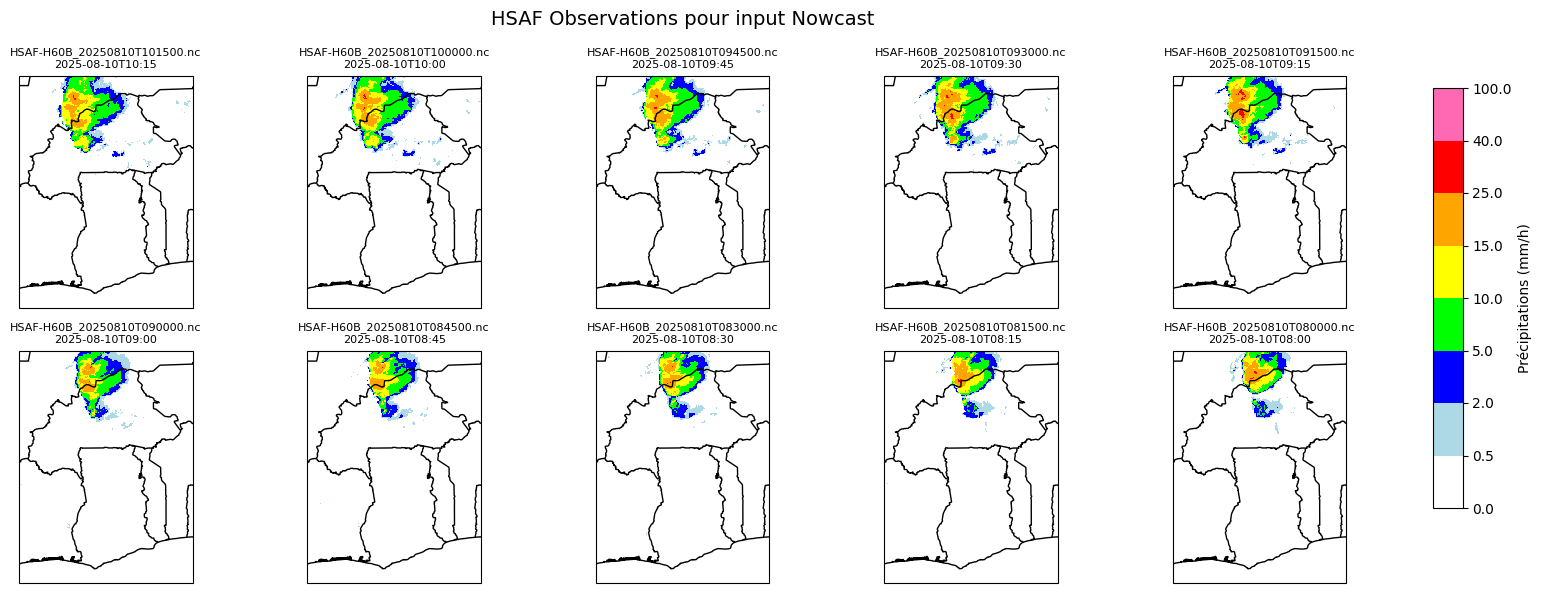

In [8]:
# --- Paramètres de la région d'intérêt ---
region = {"lat_min": 4, "lat_max": 16, "lon_min": -6, "lon_max": 3}

# --- Bornes et couleurs personnalisées pour la précipitation ---
bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]  # Bornes des intensités
colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
          "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]  # Couleurs associées
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# --- Configuration des subplots ---
max_per_row = 5                             # Maximum de subplots par ligne
n_files = len(input_files)
n_rows = math.ceil(n_files / max_per_row)  # Nombre de lignes nécessaires

# Création de la figure avec subplots plus petits -
fig_width = max_per_row * 3
fig_height = n_rows * 3
fig, axes = plt.subplots(n_rows, max_per_row, figsize=(fig_width, fig_height),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()  

# Boucle sur chaque fichier pour créer un subplot
for i, f in enumerate(input_files):
    ds = xr.open_dataset(f)
    
    # Sélection de la région et première timestep
    data = ds.sel(
        x=slice(region["lon_min"], region["lon_max"]),
        y=slice(region["lat_max"], region["lat_min"])  # attention aux coordonnées inversées
    ).precip_intensity.isel(time=0)
    
    # Masquer les zones sans précipitation
    data_masked = data.where(data > 0)
    
    ax = axes[i]
    ax.set_extent([region["lon_min"], region["lon_max"], region["lat_min"], region["lat_max"]])
    ax.coastlines(resolution='10m', color='black')
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    
    # Tracer les précipitations
    im = ax.pcolormesh(
        data_masked["x"], data_masked["y"], data_masked,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm
    )
    
    # Ajouter titre pour chaque subplot avec nom de fichier et timestamp
    timestamp_str = str(data.time.values)[:16]
    ax.set_title(f"{f.name}\n{timestamp_str}", fontsize=8)

# Supprimer les subplots vides
for j in range(i+1, n_rows*max_per_row):
    fig.delaxes(axes[j])

# Ajouter une colorbar verticale à droite de toutes les subplots 
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', label="Précipitations (mm/h)")

# Titre général de la figure 
fig.suptitle("HSAF Observations pour input Nowcast", fontsize=14)
plt.tight_layout()
plt.show()

# Étape 7 : Exécuter le modèle de nowcast STEPS avec Pysteps
Cette commande exécute le modèle de nowcast STEPS sur les données de précipitations que vous avez sélectionnées (dataset_roi), c’est-à-dire la région d’intérêt que vous avez définie précédemment.
Les paramètres du nowcast (nombre de pas de temps, fréquence, nombre d’ensembles, seuils, etc.) sont récupérés depuis les settings définis à l’étape 2.

In [9]:
dataset_roi = input_dataset.sel(
    x=slice(region["lon_min"], region["lon_max"]),
    y=slice(region["lat_max"], region["lat_min"])  # attention aux coordonnées inversées
)

nowcast_arrays, metadata = engine.nowcast_steps_pysteps(dataset_roi)

Rain fraction is: 0.10014747589336359, while minimum fraction is 0.005
unknown projection longlat
Inputs validated and initialized successfully.
Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 287x215
km/pixel:         3.0
time step:        15 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   None
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
ensemble size:            5
parallel threads:         2
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -13.010299956639813
Nowcast components initialized successfully.
Rain fraction is: 0.09191043405450666, while minimum fraction is 0.0
Extrapolation complete a

# Étape 8 : Exporter les résultats vers un fichier NetCDF
Un fichier NetCDF (Network Common Data Form) est un format de fichier utilisé pour stocker des données multidimensionnelles, comme les précipitations sur une grille spatiale et temporelle. Il permet de conserver les informations sur les coordonnées (latitude, longitude, temps), les variables (ici l’intensité des précipitations) et les métadonnées.


In [10]:
output_path = "/workspaces/Tools-for-weather-and-climate-services-in-Africa/4. Create Nowcast using HSAF H60B data/h60b_data/nowcast"
Path(output_path).mkdir(parents=True, exist_ok=True)
engine.settings["threddsdata"] = output_path        #VG

# Nu kan je gewoon exporteren zonder extra argument
engine.export_nowcast_to_netcdf(
    country="Togo_BurkinaFaso",
    nowcasting_arrays=nowcast_arrays,
    date_start=None,  #L'exporteur déduit la date de début à partir de la pile de données d'entrée; on peut la définir explicitement si nécessaire
    metadata=metadata,
    reproject=True,
    data_source=settings["data_source"],
)

# Étape 9 : Inspecter et visualiser les résultats du nowcast

In [11]:
# Ouvrir le fichier NetCDF contenant les résultats du nowcast
ds = xr.open_dataset(nowcasting_folder / "pysteps_h60b_latest.nc")

# Afficher quelques informations sur le fichier NetCDF
print("Dimensions du fichier NetCDF :", ds.dims)
print("Variables disponibles :", list(ds.data_vars))
print("Coordonnées :", list(ds.coords))
print("Attributs :", ds.attrs)

Dimensions du fichier NetCDF : FrozenMappingWarningOnValuesAccess({'x': 215, 'y': 287, 'ens_number': 5, 'time': 12})
Variables disponibles : ['lon', 'lat', 'precip_intensity']
Coordonnées : ['x', 'y', 'ens_number', 'time']
Attributs : {'Conventions': 'CF-1.7', 'title': 'pysteps-generated nowcast', 'institution': 'the pySTEPS community (https://pysteps.github.io)', 'source': 'pysteps', 'history': '', 'references': '', 'comment': '', 'projection': '+proj=longlat +datum=WGS84 +no_defs'}


Visualiser un pas de temps du nowcast

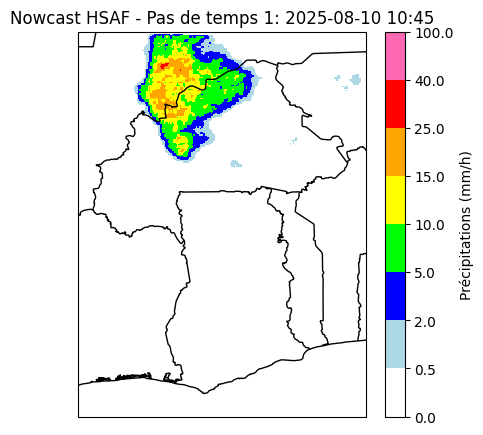

In [12]:
# Charger le dataset Nowcast HSAF 
ds = xr.open_dataset(nowcasting_folder / "pysteps_h60b_latest.nc")

# Chaque pas de temps correspond à 15 minutes dans le futur
time_index = 1 
data_plot = ds.isel(ens_number=0).precip_intensity.isel(time=time_index)

# Masquer les zones sans précipitations (0 mm/h)
data_plot_masked = data_plot.where(data_plot > 0)

# Définir les bornes et couleurs personnalisées pour la carte 
bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]  # Bornes des intensités de pluie (mm/h)
colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
          "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]  # Couleurs associées aux intervalles
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# Inverser uniquement les données de précipitations sur l'axe y 
# Cela corrige l'orientation de la pluie tout en laissant la carte de fond intacte
data_flipped = data_plot_masked.values[::-1, :]

# Créer la figure et définir la projection 
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([ds.x.min(), ds.x.max(), ds.y.min(), ds.y.max()], crs=ccrs.PlateCarree())

# Ajouter la carte de fond 
ax.coastlines(resolution='10m', color='black')  # Côtes
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')  # Frontières des pays

# Tracer les précipitations inversées 
im = ax.pcolormesh(
    ds.x, ds.y, data_flipped,  
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm
)

# Ajouter la barre de couleur
cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, label="Précipitations (mm/h)")

#  Ajouter le titre avec le timestamp du pas de temps 
time_str = pd.to_datetime(ds.time.isel(time=time_index).values).strftime("%Y-%m-%d %H:%M")
plt.title(f"Nowcast HSAF - Pas de temps {time_index}: {time_str}")

# Afficher la figure 
plt.show()

Créer une vidéo des images du nowcast

In [13]:
# --- Charger le dataset Nowcast ---
ds = xr.open_dataset(nowcasting_folder / "pysteps_h60b_latest.nc")

# Choisir la variable de précipitations
varname = "precip_intensity" if "precip_intensity" in ds.data_vars else "precipitation"
var = ds[varname]

# Sélectionner le premier membre d'ensemble si présent
if "ens_number" in var.dims:
    var = var.isel(ens_number=0)

# Fonction pour formater les titres avec date et heure
def fmt_time(tarr, i):
    v = tarr.isel(time=i).values
    try:
        return np.datetime_as_string(np.asarray(v, dtype="datetime64[m]"), unit='m')
    except Exception:
        try:
            return v.strftime("%Y-%m-%d %H:%M")
        except Exception:
            return str(v)

# Définir les bornes et les couleurs personnalisées
bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]
colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
          "#ffff00", "#ffa500", "#ff0000", "#ff69b4", "#ff69b4"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N, extend='max')
cmap.set_bad("none")  # NaN waarden worden transparant

# Extraire les coordonnées
xname = next((c for c in ("x","lon","longitude") if c in var.coords), None)
yname = next((c for c in ("y","lat","latitude") if c in var.coords), None)
x = var[xname].values
y = var[yname].values

# Définir l'étendue pour l'affichage
if y[0] > y[-1]:
    extent = [x.min(), x.max(), y.max(), y.min()]
    origin = "upper"
else:
    extent = [x.min(), x.max(), y.min(), y.max()]
    origin = "lower"

# Créer la figure et les axes avec Cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
plt.close(fig)  
ax.set_extent([x.min(), x.max(), y.min(), y.max()])
ax.coastlines(resolution='10m', color='black')
ax.add_feature(cfeature.BORDERS, edgecolor='black')

# Premier frame avec masked array
first_frame = var.isel(time=0).where(var.isel(time=0) > 0)
first_frame_flipped = np.ma.masked_invalid(first_frame.values[::-1, :]).astype(np.float32)

# Afficher le premier frame
img = ax.imshow(
    first_frame_flipped,
    extent=extent,
    origin=origin,
    cmap=cmap,
    norm=norm
)

# Ajouter la barre de couleur
cbar = fig.colorbar(img, ax=ax, fraction=0.05, pad=0.02, ticks=bounds)
cbar.set_label("Précipitations (mm/h)")

# Titre du premier frame
ax.set_title(fmt_time(var["time"], 0))

# Fonction pour mettre à jour l'animation
def update(i):
    frame = var.isel(time=i).where(var.isel(time=i) > 0)
    frame_flipped = np.ma.masked_invalid(frame.values[::-1, :]).astype(np.float32)
    img.set_data(frame_flipped)
    ax.set_title(fmt_time(var["time"], i))
    return (img,)

# Créer l'animation
ani = FuncAnimation(fig, update, frames=var.sizes["time"], interval=600, blit=True)

# Affichage dans Jupyter Notebook
HTML(ani.to_jshtml())


# Étape 10 : Extraction des précipitations du nowcast pour des points spécifiques

In [14]:
nowcast_file = nowcasting_folder / "pysteps_h60b_latest.nc"
ds = xr.open_dataset(nowcast_file)

# Définir les points d'intérêt 
points = [
    {"nom": "Lomé", "lat": 6.13, "lon": 1.21},
    {"nom": "Ouagadougou", "lat": 12.37, "lon": -1.52},
    {"nom": "Nouna", "lat": 12.76, "lon": -3.84},
]

# Sélectionner le premier membre d'ensemble si présent 
varname = "precip_intensity" if "precip_intensity" in ds.data_vars else "precipitation"
var = ds[varname]
if "ens_number" in var.dims:
    var = var.isel(ens_number=0)  # Premier membre

# Extraire les séries temporelles pour chaque point (avec Y-flip)
data_dict = {}
y_vals = var["y"].values
for pt in points:
    # trouver l'indice le plus proche de la longitude
    x_idx = abs(var["x"].values - pt["lon"]).argmin()
    # trouver l'indice le plus proche de la latitude
    y_idx = abs(var["y"].values - pt["lat"]).argmin()
    
    # Flip l'indice Y pour correspondre au flip de la carte
    y_idx_flipped = len(y_vals) - 1 - y_idx
    
    # Extraire les valeurs temporelles pour ce pixel
    rain_series = var[:, y_idx_flipped, x_idx]  # toutes les times, Y-flip, X
    data_dict[pt["nom"]] = rain_series.values


# Créer un DataFrame : lignes = timestamps, colonnes = points 
df_points = pd.DataFrame(data_dict, index=rain_series["time"].values)
df_points.index.name = "time"

# Affichage
print("Dataframe final (Nowcast) : chaque colonne = un point, chaque ligne = un pas de temps")
df_points

Dataframe final (Nowcast) : chaque colonne = un point, chaque ligne = un pas de temps


,Lomé,Ouagadougou,Nouna
time,,,
2025-08-10 10:30:00,0.0,0.069121,0.000000
2025-08-10 10:45:00,0.0,0.000000,0.000000
2025-08-10 11:00:00,0.0,0.000000,0.000000
2025-08-10 11:15:00,0.0,0.000000,0.000000
2025-08-10 11:30:00,0.0,0.000000,0.000000
2025-08-10 11:45:00,0.0,0.000000,1.070716
2025-08-10 12:00:00,0.0,0.000000,4.248220
2025-08-10 12:15:00,0.0,0.000000,4.835217
2025-08-10 12:30:00,0.0,0.000000,6.536165


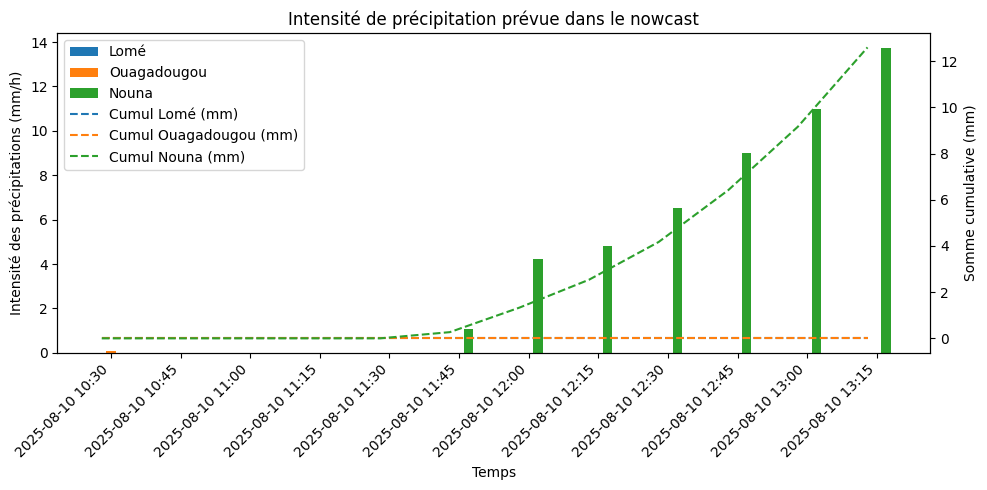

In [15]:
#  Création du graphique avec barres (intensité) et courbes (cumul corrigé)
fig, ax1 = plt.subplots(figsize=(10, 5))

# Création d’un vecteur pour l’axe des X
x = np.arange(len(df_points.index))
width = 0.4 / len(df_points.columns)  # largeur des barres par point

# Tracer les barres pour chaque point (intensité en mm/h)
for i, col in enumerate(df_points.columns):
    ax1.bar(
        x + i * width,                # Décalage des barres
        df_points[col].values,        # Valeurs d’intensité (mm/h)
        width=width, 
        label=col
    )

# Mise en forme de l’axe X avec les timestamps
ax1.set_xticks(x + width * (len(df_points.columns) - 1) / 2)
ax1.set_xticklabels(df_points.index.strftime("%Y-%m-%d %H:%M"), rotation=45, ha="right")

ax1.set_ylabel("Intensité des précipitations (mm/h)")
ax1.set_xlabel("Temps")

# Conversion en mm par pas de 15 minutes
df_points_mm = df_points * 0.25   # mm/h * 0.25 = mm/15min

# Ajouter un second axe Y pour les cumuls
ax2 = ax1.twinx()
for col in df_points.columns:
    ax2.plot(
        x, 
        df_points_mm[col].cumsum(), linestyle="--",
        label=f"Cumul {col} (mm)"
    )

ax2.set_ylabel("Somme cumulative (mm)")

# Fusion des légendes (barres + courbes)
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc="upper left")

plt.title("Intensité de précipitation prévue dans le nowcast")
plt.tight_layout()
plt.show()

# Étape 11 : Choisir les seuils d’alerte
Le nowcast peut fournir une prévision des précipitations pour les prochaines périodes. Sur la base de cette prévision, des alertes peuvent être émises en cas de pluies extrêmes. Les seuils pour émettre ces alertes varient selon les endroits. Dans cette partie du script, nous pouvons expérimenter avec les seuils et observer l’effet sur l’émission des alertes à différents endroits.

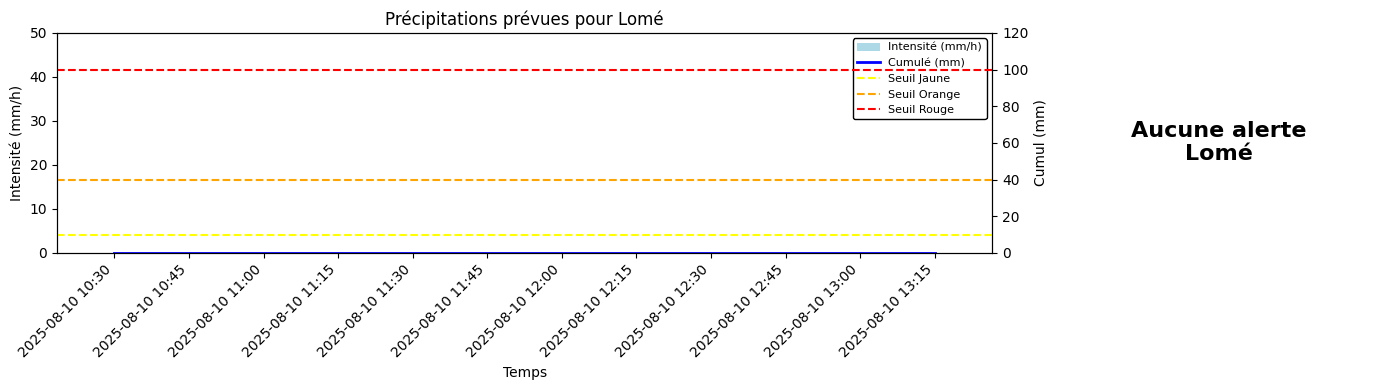

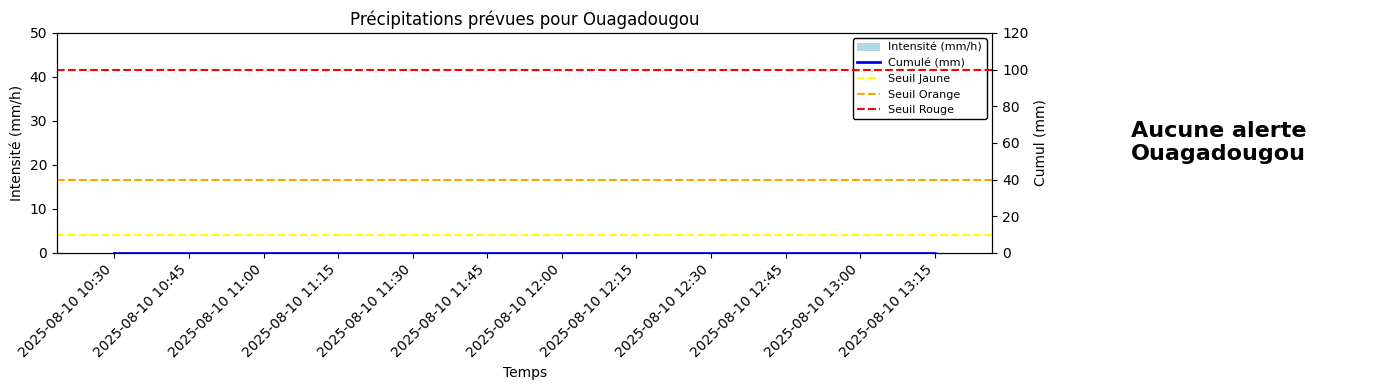

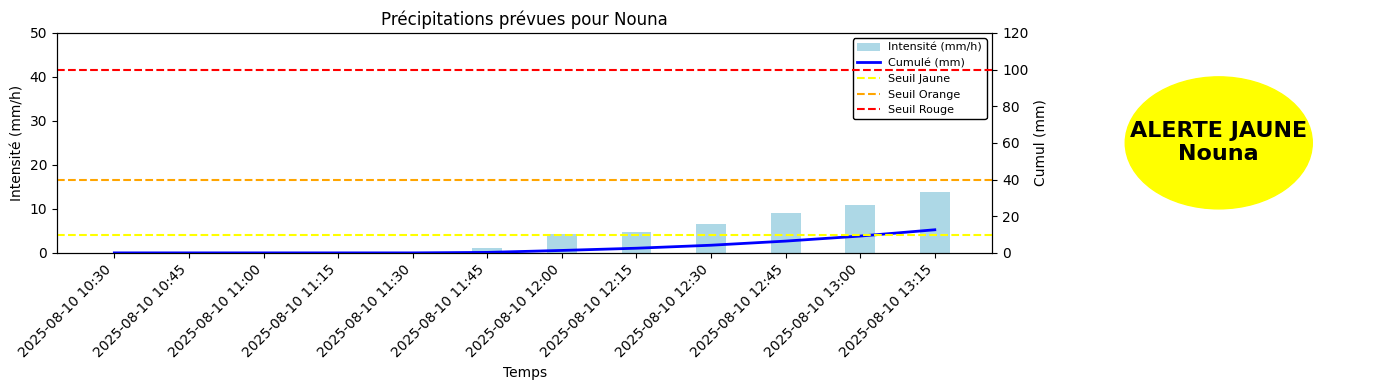

In [16]:
# Seuils d'alerte et couleurs associées
seuils = {"jaune": 10, "orange": 40, "rouge": 100}
couleurs = {"jaune": "yellow", "orange": "orange", "rouge": "red"}

# Conversion intensité -> cumul par pas de 15 min
df_mm = df_points * 0.25   # mm/h * 0.25 h = mm / 15 min
df_cum = df_mm.cumsum()

# Boucle pour chaque point
for point in df_points.columns:
    x = np.arange(len(df_points.index))

    # Déterminer le niveau d'alerte
    niveau_alerte = None
    for niveau, seuil in sorted(seuils.items(), key=lambda x: x[1]):
        if df_cum[point].max() >= seuil:
            niveau_alerte = niveau

    # Création de la figure avec 2 sous-graphes horizontaux
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={"width_ratios": [3, 1]})

    # Histogramme pour l'intensité
    ax1.bar(x, df_points[point].values, color="lightblue", width=0.4, label="Intensité (mm/h)")

    # Ligne cumulée sur un axe Y secondaire
    ax_cum = ax1.twinx()
    ax_cum.plot(x, df_cum[point].values, color="blue", linewidth=2, label="Cumulé (mm)")

    # Lignes de seuils
    for niveau, seuil in seuils.items():
        ax_cum.axhline(seuil, color=couleurs[niveau], linestyle="--", label=f"Seuil {niveau.capitalize()}")

    # Mise en forme de l'axe X et des axes Y
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_points.index.strftime("%Y-%m-%d %H:%M"), rotation=45, ha="right")
    ax1.set_xlabel("Temps")
    ax1.set_ylabel("Intensité (mm/h)")
    ax_cum.set_ylabel("Cumul (mm)")
    ax1.set_ylim(0, max(df_points[point].max(), 50))
    ax_cum.set_ylim(0, max(df_cum[point].max(), 120))
    ax1.set_title(f"Précipitations prévues pour {point}")

    # Fusion des légendes avec fond blanc et au-dessus des lignes
    lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax_cum]]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    legend = ax1.legend(lines, labels, loc="upper right", fontsize=8, facecolor="white",
                        edgecolor="black", framealpha=1)

    # Sous-graphe alarme à droite
    ax2.axis('off')
    if niveau_alerte:
        circle_color = couleurs[niveau_alerte]
        ax2.add_patch(plt.Circle((0.5, 0.5), 0.3, color=circle_color))
        ax2.text(0.5, 0.5, f"ALERTE {niveau_alerte.upper()}\n{point}",
                 color="black", fontsize=16, ha="center", va="center", weight="bold")
    else:
        ax2.text(0.5, 0.5, f"Aucune alerte\n{point}",
                 color="black", fontsize=16, ha="center", va="center", weight="bold")

    plt.tight_layout()
    plt.show()